In [1]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Load the workbook
workbookPath = 'Gutman Output Cons Dent 08042024 ALL v2.xlsx'
workbook = openpyxl.load_workbook(workbookPath, data_only=True)
sheet = workbook['All Data Pivot (2)']

# Read data into a pandas DataFrame
data = sheet.values
# Get the first row of headers (to be skipped)
next(data)
# Get the second row as headers
columns = next(data)

# Create the DataFrame
df = pd.DataFrame(data, columns=columns)
df[['StudentID', 'MarkerID']] = df['Row Labels'].str.split('_', expand=True)
df = df[:190]
# print(df)


Let's first work with aggregate info of each marker and compare with the overall

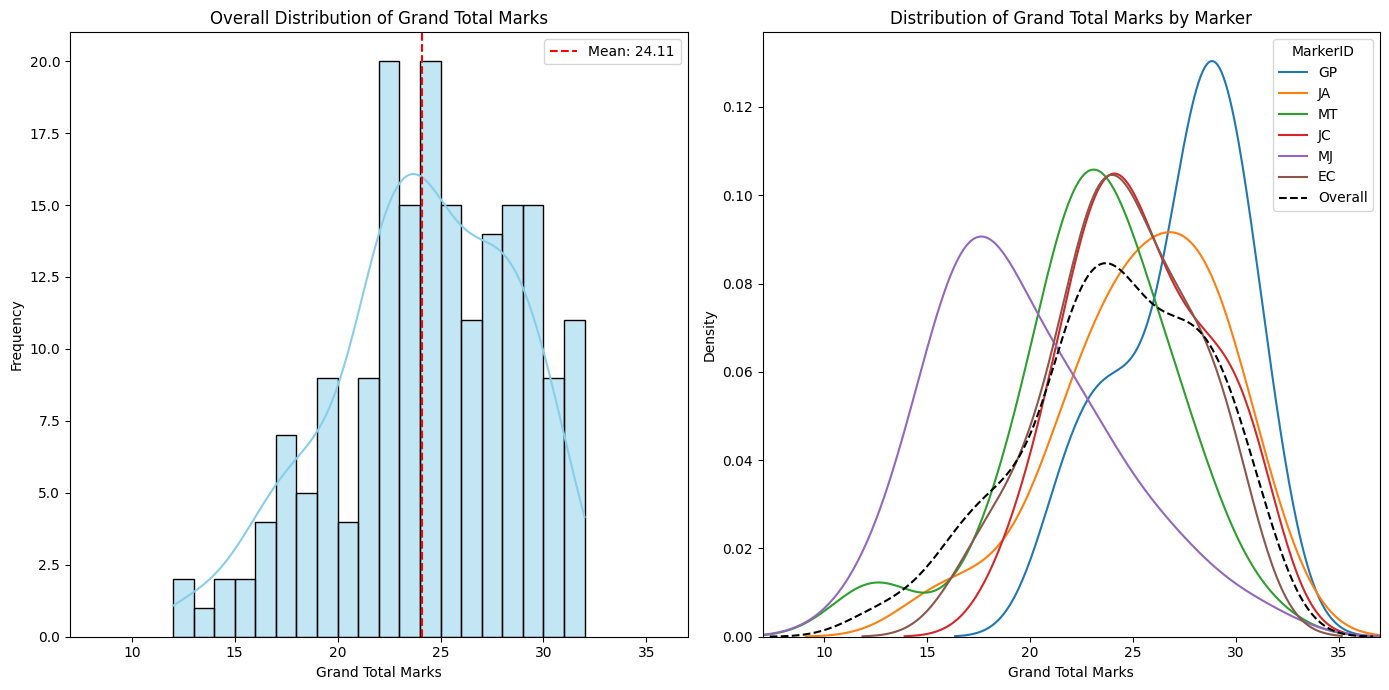

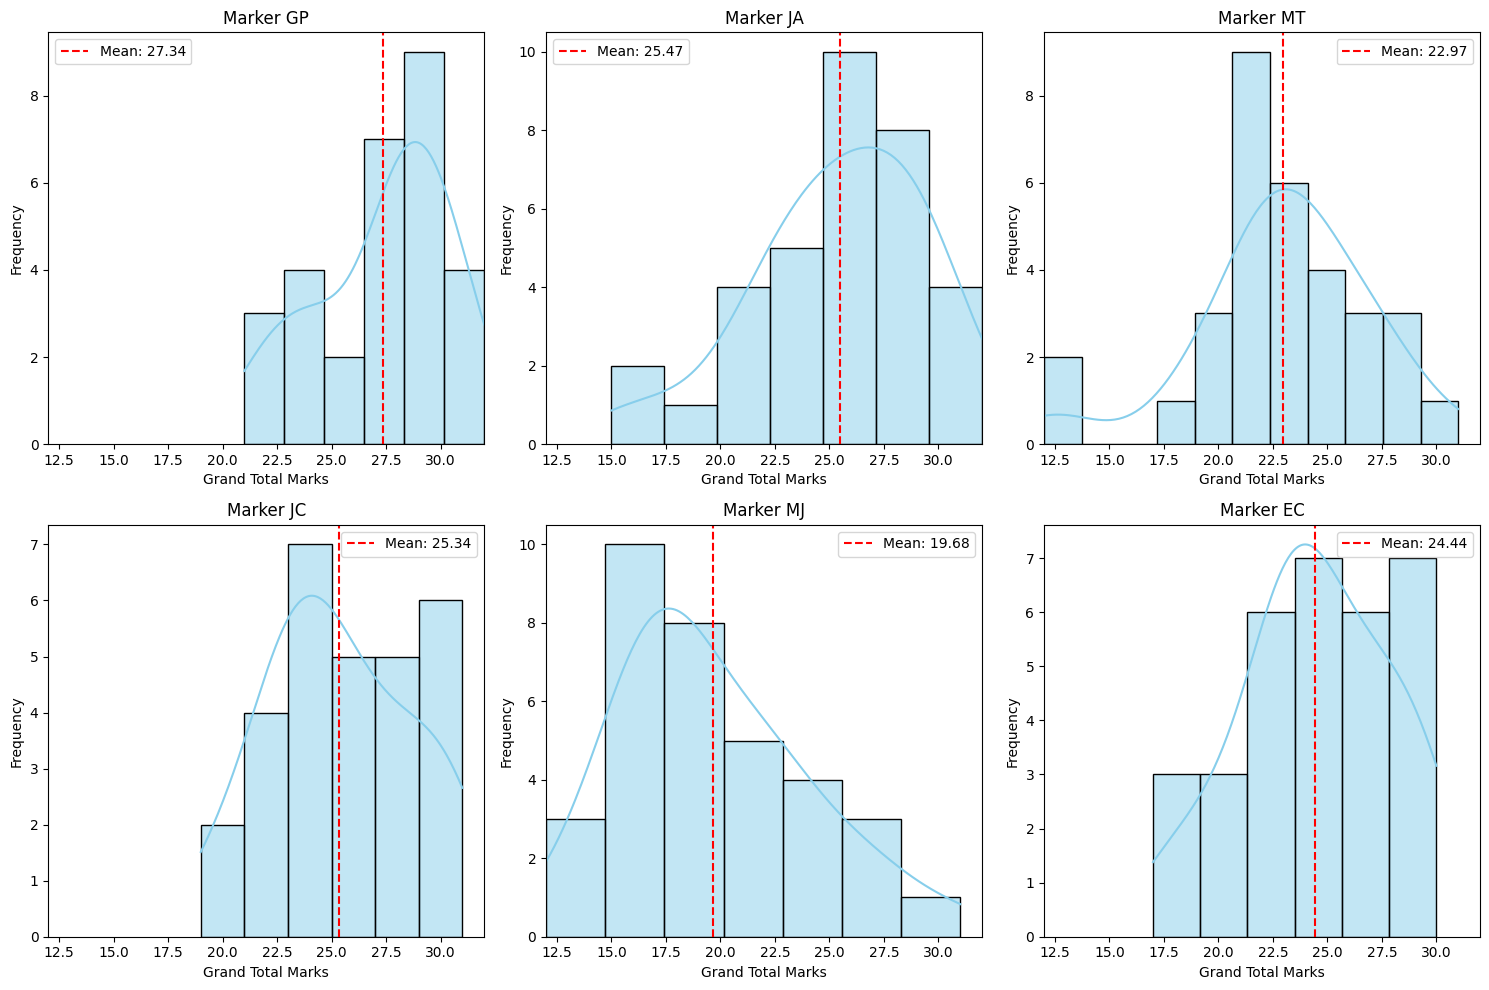

({'Average': 24.105263157894736, 'Std': 4.4280818263148936},
             Average  Std Deviation
 MarkerID                          
 EC        24.437500       3.426062
 GP        27.344828       3.038748
 JA        25.470588       3.986609
 JC        25.344828       3.330335
 MJ        19.676471       4.353477
 MT        22.968750       4.011953)

In [2]:
# Overall aggregate, average of grand total for all
overall_stats = {
    'Average': df['Grand Total'].mean(),
    'Std': df['Grand Total'].std()
}
marker_stats = df.groupby('MarkerID')['Grand Total'].agg(['mean', 'std']).rename(columns={'mean': 'Average', 'std': 'Std Deviation'})

plt.figure(figsize=(14, 7))
# Overall distribution
plt.subplot(1, 2, 1)
sns.histplot(df['Grand Total'], kde=True, color="skyblue", bins=20)
plt.title('Overall Distribution of Grand Total Marks')
plt.xlabel('Grand Total Marks')
plt.xlim(df['Grand Total'].min() - 5, df['Grand Total'].max() + 5)
plt.ylabel('Frequency')
plt.axvline(df['Grand Total'].mean(), color='r', linestyle='--', label=f"Mean: {overall_stats['Average']:.2f}")
# plt.axvline(df['Grand Total'].mean() + df['Grand Total'].std(), color='g', linestyle='--', label=f"+1 Std Dev: {(df['Grand Total'].mean() + df['Grand Total'].std()):.2f}")
# plt.axvline(df['Grand Total'].mean() - df['Grand Total'].std(), color='g', linestyle='--', label=f"-1 Std Dev: {(df['Grand Total'].mean() - df['Grand Total'].std()):.2f}")
plt.legend()

# Distribution for each marker in subplots might be too many, so let's show one combined plot instead
plt.subplot(1, 2, 2)
for marker in df['MarkerID'].unique():
    sns.kdeplot(df[df['MarkerID'] == marker]['Grand Total'], label=marker)
sns.kdeplot(df['Grand Total'], color='black', label='Overall', linestyle='--')
plt.title('Distribution of Grand Total Marks by Marker')
plt.xlabel('Grand Total Marks')
plt.ylabel('Density')
plt.legend(title='MarkerID')
plt.xlim(df['Grand Total'].min() - 5, df['Grand Total'].max() + 5)
plt.tight_layout()
plt.show()

# Assuming 'df' contains your DataFrame and 'marker_stats' contains statistics for each marker
markers = df['MarkerID'].unique()
n_markers = len(markers)
n_cols = 3
n_rows = n_markers // n_cols + (n_markers % n_cols > 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, marker in enumerate(markers):
    ax = axs[i // n_cols, i % n_cols]
    sns.histplot(df[df['MarkerID'] == marker]['Grand Total'], kde=True, color="skyblue", ax=ax)
    ax.set_title(f'Marker {marker}')
    ax.set_xlabel('Grand Total Marks')
    ax.set_ylabel('Frequency')
    ax.set_xlim(df['Grand Total'].min(), df['Grand Total'].max())
    # Add mean line
    ax.axvline(marker_stats.loc[marker, 'Average'], color='r', linestyle='--', label=f"Mean: {marker_stats.loc[marker, 'Average']:.2f}")
    ax.legend()

# If the number of markers is not a multiple of the number of columns, hide the empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

overall_stats, marker_stats

MJ GP should be mixed together, others can be mixed in any way possible

In [3]:
df_dropped = df.drop(['Row Labels', 'Grand Total'], axis=1)

# This step aggregates data points by each marker across all students
df_pivoted = df_dropped.set_index(['StudentID', 'MarkerID']).stack().reset_index()
df_pivoted.columns = ['StudentID', 'MarkerID', 'Question', 'Score']

# Group by marker and question to calculate average scores for fairness comparison
marker_fairness = df_pivoted.groupby(['MarkerID', 'Question']).agg(AverageScore=('Score', 'mean')).reset_index()

# Display the first few rows to see the marker's fairness
marker_fairness.head()



,MarkerID,Question,AverageScore
0,EC,524_E-1,1.0
1,EC,524_E-2,0.9375
2,EC,524_E-3,0.40625
3,EC,524_E-4,0.0
4,EC,524_MC1,0.65625


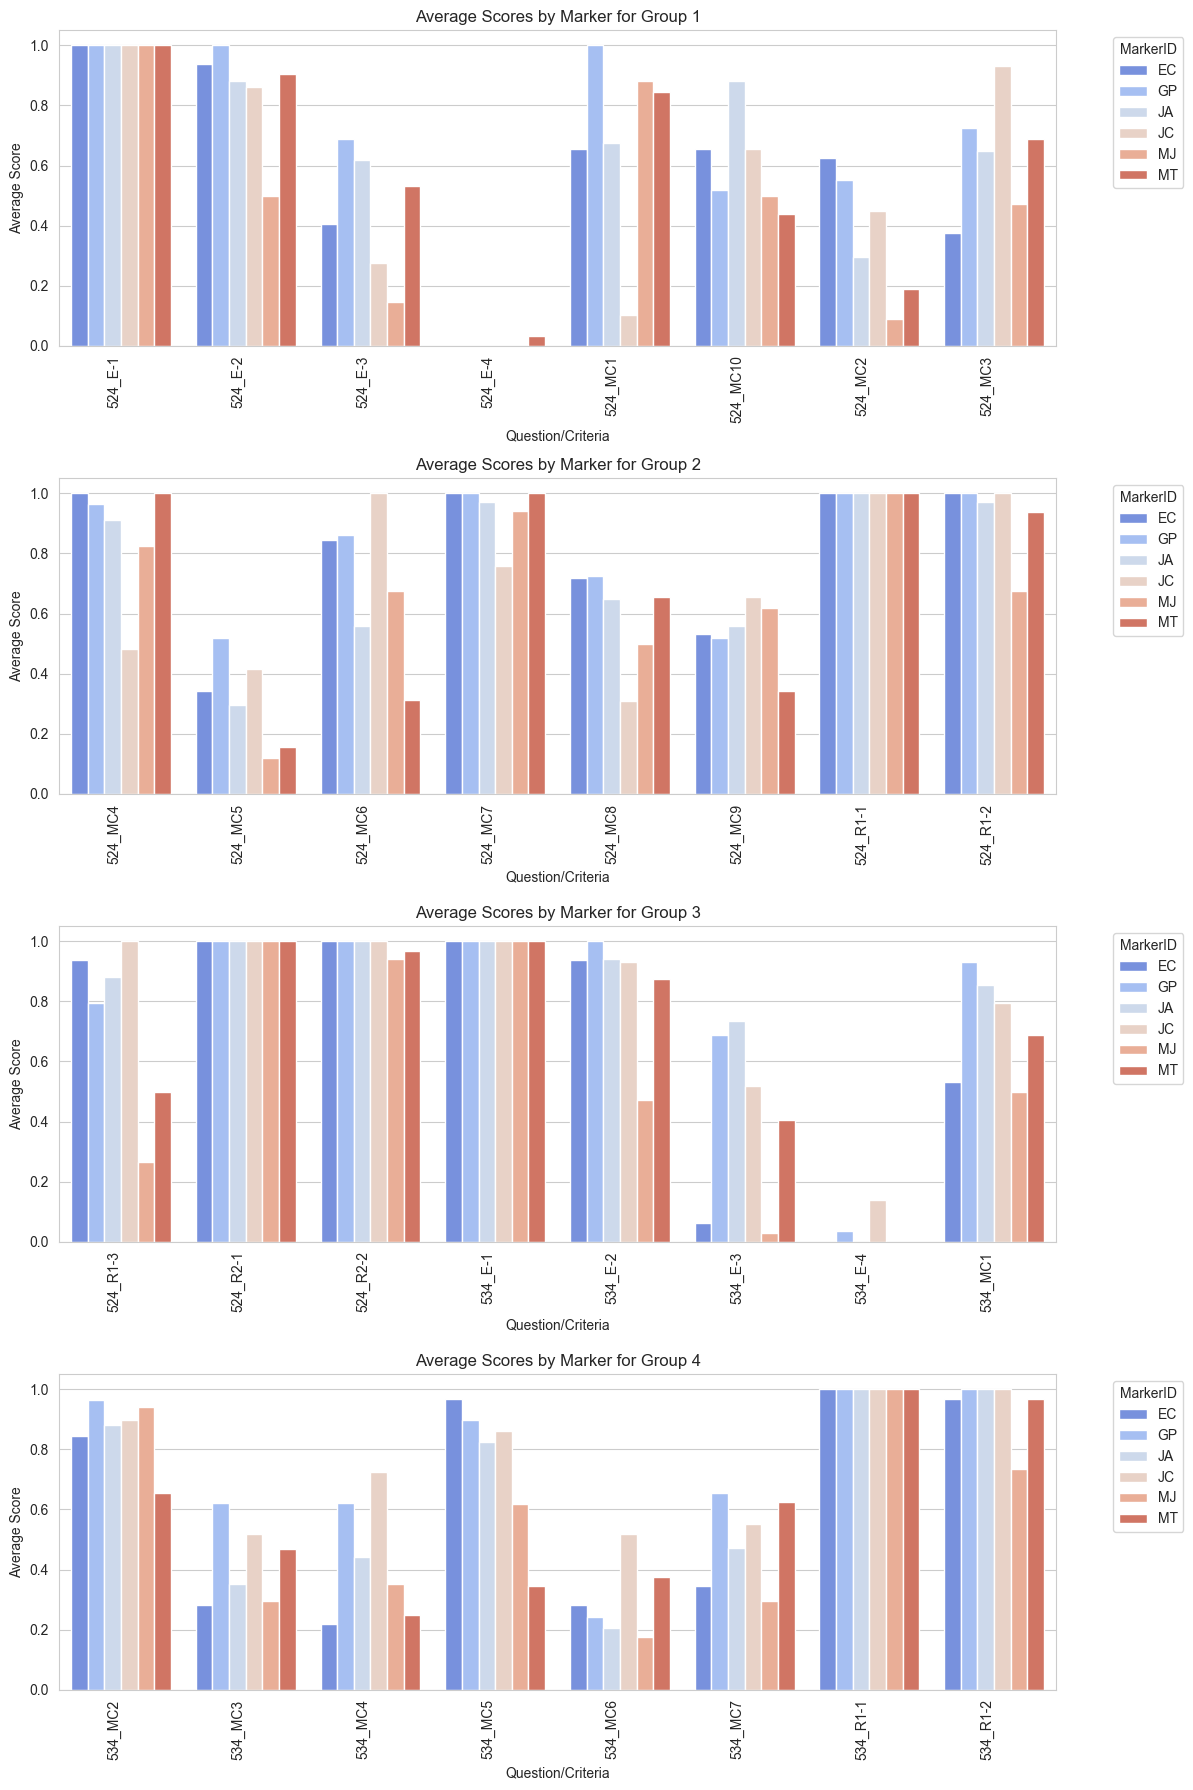

In [4]:
import matplotlib.pyplot as plt


# Set the style of the plots
sns.set_style("whitegrid")

# Extract unique markers
markers = marker_fairness['MarkerID'].unique()

# Create a figure for individual plots for each marker
# fig, axs = plt.subplots(len(markers), 1, figsize=(10, 5*len(markers)))

# for i, marker in enumerate(markers):
#     # Filter data for the current marker
#     data = marker_fairness[marker_fairness['MarkerID'] == marker]
    
#     # Plot
#     sns.barplot(x='Question', y='AverageScore', data=data, ax=axs[i], palette='cool')
#     axs[i].set_title(f'Average Scores by {marker}')
#     axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90, ha="right")
#     axs[i].set_xlabel('Question/Criteria')
#     axs[i].set_ylabel('Average Score')

# plt.tight_layout()
# plt.show()

question_groups = marker_fairness['Question'].unique()
num_groups = 4
group_size = len(question_groups) // num_groups

plt.figure(figsize=(12, 18))

for i in range(num_groups):
    plt.subplot(num_groups, 1, i+1)
    group_questions = question_groups[i*group_size:(i+1)*group_size]
    data_subset = marker_fairness[marker_fairness['Question'].isin(group_questions)]
    
    sns.barplot(x='Question', y='AverageScore', hue='MarkerID', data=data_subset, palette='coolwarm')
    plt.title(f'Average Scores by Marker for Group {i+1}')
    plt.xticks(rotation=90, ha="right")
    plt.xlabel('Question/Criteria')
    plt.ylabel('Average Score')
    plt.legend(title='MarkerID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Let's test MJ's student's marks with other markers

In [5]:
allMarkers = df['MarkerID'].unique()
# Extract marker MJ
for marker in allMarkers:
    dfMJ = df[df['MarkerID'] == marker]
    # print(dfMJ)
    MJStudents = dfMJ['StudentID'].unique()
    # print(MJStudents)
    # Now get data for MJ students from df
    dfMJStudents = df[df['StudentID'].isin(MJStudents)]
    # print(dfMJStudents)
    MJData = dfMJStudents[dfMJStudents['MarkerID'] == marker]
    otherData = dfMJStudents[dfMJStudents['MarkerID'] != marker]
    print(MJData['MarkerID'].unique(), otherData['MarkerID'].unique())



['GP'] ['JC']
['JA'] ['MJ']
['MT'] ['EC']
['JC'] ['GP']
['MJ'] ['JA']
['EC'] ['MT']


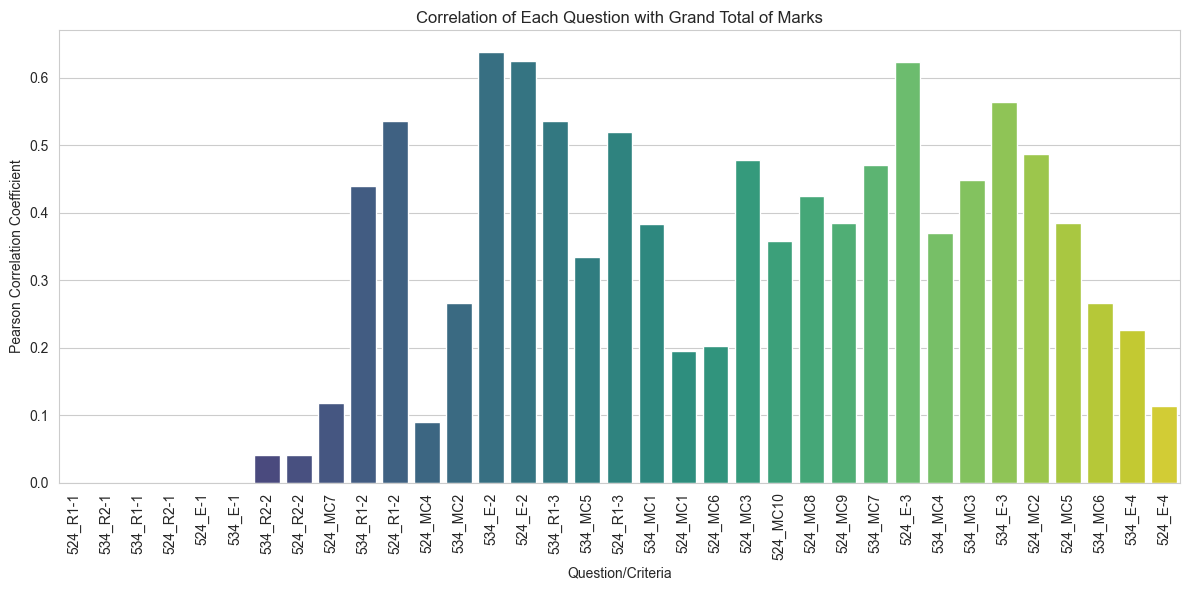

<Figure size 2000x1500 with 0 Axes>

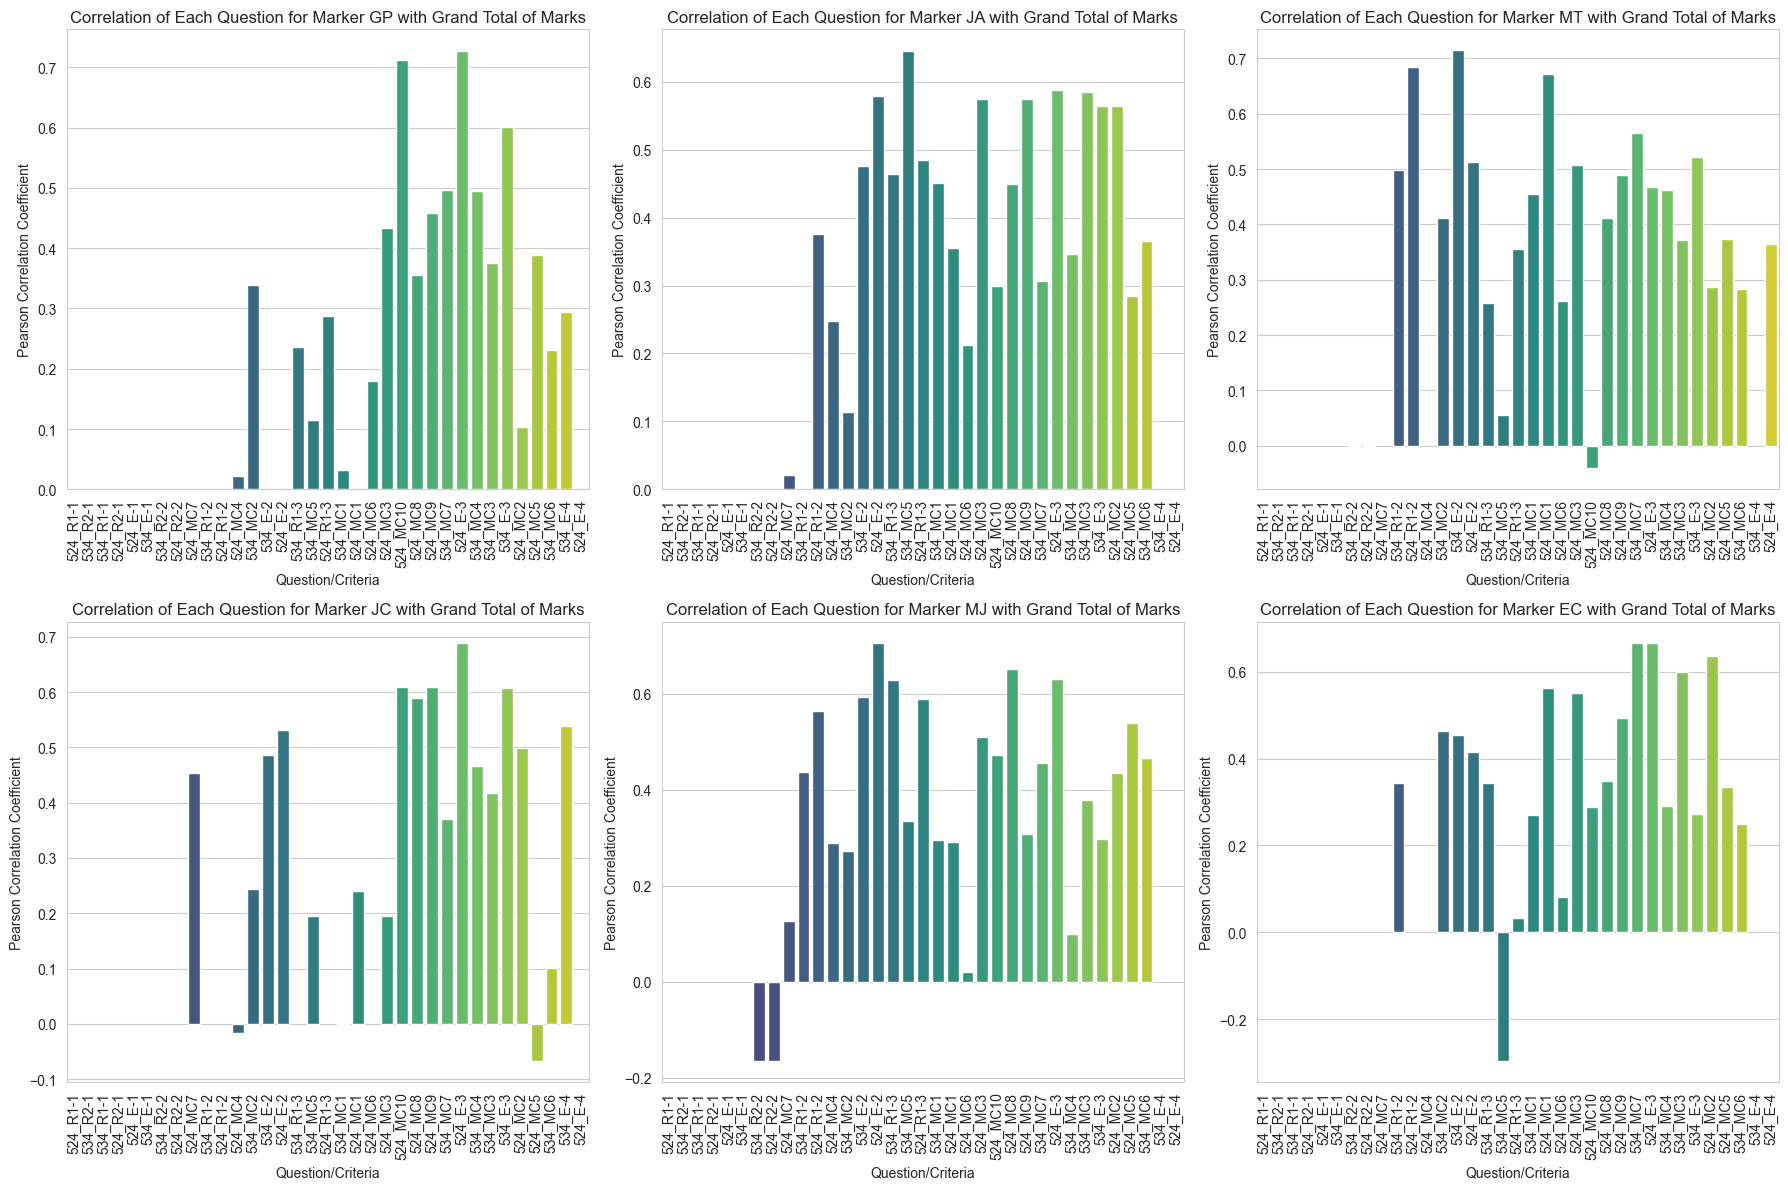

In [6]:
# Calculate the correlation between each question and the Grand Total
df_marks = df.iloc[:, 1:-2]
# print(df_marks)
# df_marks = df_marks[:-3]

corr_grand_total = df_marks.corr('pearson')[df_marks.columns[-1]][:-1]
df_corr = pd.DataFrame(list(corr_grand_total.items()), columns=['Question', 'Correlation'])
# print(corr_grand_total)
plt.figure(figsize=(12, 6))
sns.barplot(x='Question', y='Correlation', data=df_corr, palette='viridis')
plt.title('Correlation of Each Question with Grand Total of Marks')
plt.xticks(rotation=90, ha="center")
plt.xlabel('Question/Criteria')
plt.ylabel('Pearson Correlation Coefficient')
plt.tight_layout()
plt.show()


plt.figure(figsize=(20, 15))
nRows = 2
nCols = 3
fig, axes = plt.subplots(nRows, nCols, figsize=(18, 12))  # Adjust the figsize to fit your display
axes = axes.flatten()  # Flatten the axes array for easy iteration

for index, marker in enumerate(allMarkers):
    dfMJ = df[df['MarkerID'] == marker]
    dfMJ = dfMJ.iloc[:, 1:-2]
    corrGrandTotal = dfMJ.corr('pearson')[dfMJ.columns[-1]][:-1]
    dfCorr = pd.DataFrame(list(corrGrandTotal.items()), columns=['Question', 'Correlation'])
    
    sns.barplot(x='Question', y='Correlation', data=dfCorr, palette='viridis', ax=axes[index])
    axes[index].set_title('Correlation of Each Question for Marker ' + marker + ' with Grand Total of Marks')
    axes[index].tick_params(axis='x', rotation=90)
    axes[index].set_xlabel('Question/Criteria')
    axes[index].set_ylabel('Pearson Correlation Coefficient')

# If the number of markers is less than the number of subplots, turn off the extra axes
for i in range(len(allMarkers), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
marker_correlations = {}
for marker in df['MarkerID'].unique():
    # Filter the DataFrame for the current marker
    marker_df = df[df['MarkerID'] == marker]
    # Calculate the correlation for this subset
    corr = marker_df.corrwith(marker_df['Grand Total']).drop('Grand Total')
    marker_correlations[marker] = corr

# Convert the marker-wise correlations into a DataFrame for easier analysis
marker_correlations_df = pd.DataFrame(marker_correlations)
print(marker_correlations_df)


ValueError: could not convert string to float: '1420060_GP'

## Raw Data Analysis

For the analysis discussed on 12/04/24

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
choiceTextFile = 'For Kunal - Choic text CAF v0.1_April 11, 2024_23.09.xlsx'
numericValueFile = 'For Kunal - Numeric values CAF v0.1_April 11, 2024_23.09 2.xlsx'

choiceTextDf = pd.read_excel(choiceTextFile)
numericValueDf = pd.read_excel(numericValueFile)

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
headerKeyChoiceText = dict(zip(choiceTextDf.columns, choiceTextDf.iloc[0]))
# choiceTextDf.drop(index=choiceTextDf.index[0], axis=0, inplace=True)
choiceTextDf.dropna(axis=1, how='all', inplace=True)
# choiceTextDf.head()
# for choiceTextColumn in choiceTextDf.columns:
#     print(f'{choiceTextColumn}:  {headerKeyChoiceText[choiceTextColumn]}') 

### Extract ORAL20005

In [5]:
oral20005df = choiceTextDf[choiceTextDf['Q8'] == 'ORAL20005']
print(oral20005df.shape)
# oral20005df.head()
# oral20005df[(oral20005df['Q3'] == 'Paloma') | (oral20005df['Q4'] == 'Paloma')]
# oral20005df[oral20005df.isin(['ORAL20005']).any(axis=1)]

(1217, 1266)


### Extract ORAL30002

In [6]:
oral30002df = choiceTextDf[choiceTextDf['Q8'] == 'ORAL30002']
print(oral30002df.shape)
# oral30002df.head()

(211, 1266)


Extract Info about Students

%age finished: 25/29 = 86.21%
Number of Critical incidents:
Yes - 0
No - 25


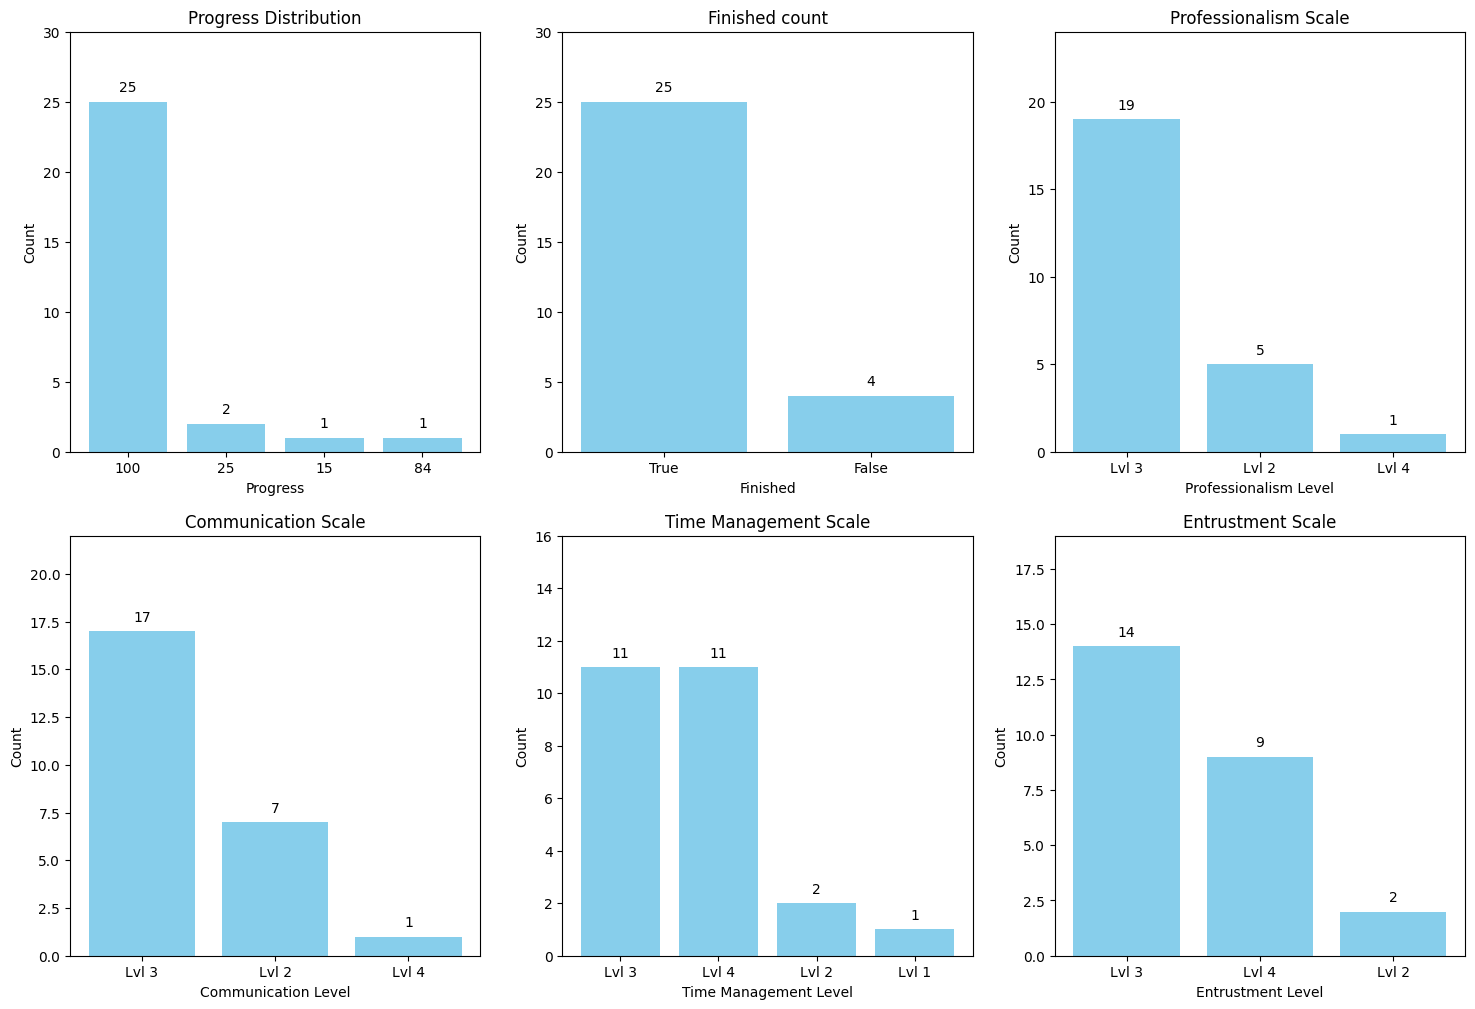

%age finished: 9/12 = 75.00%
Number of Critical incidents:
Yes - 0
No - 10


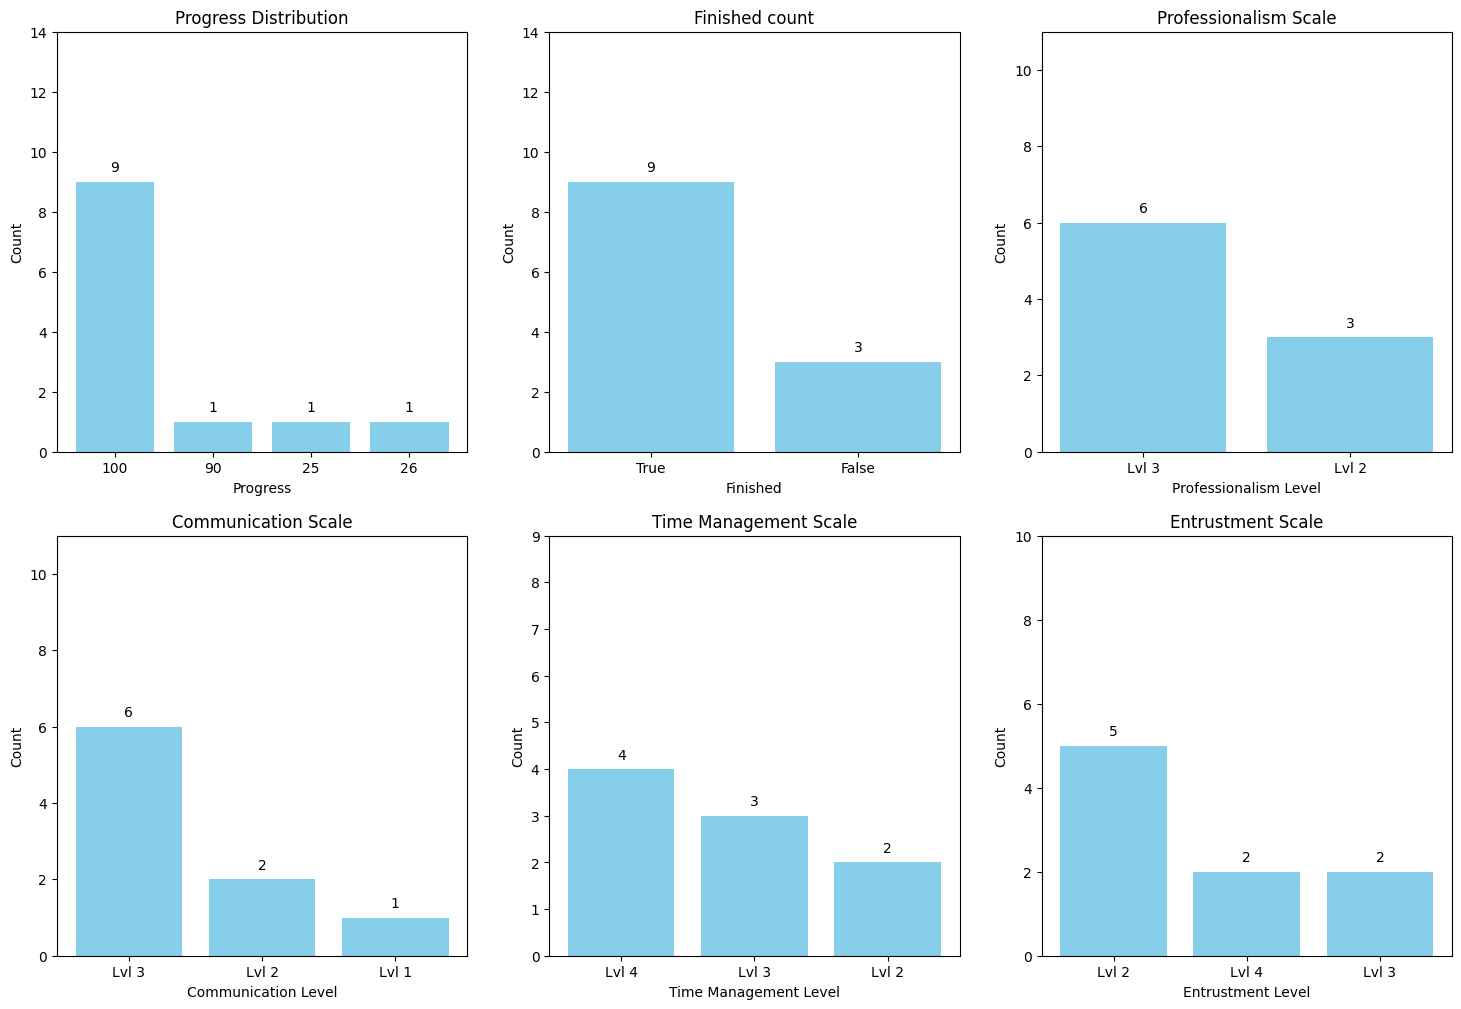

%age finished: 19/22 = 86.36%
Number of Critical incidents:
Yes - 0
No - 19


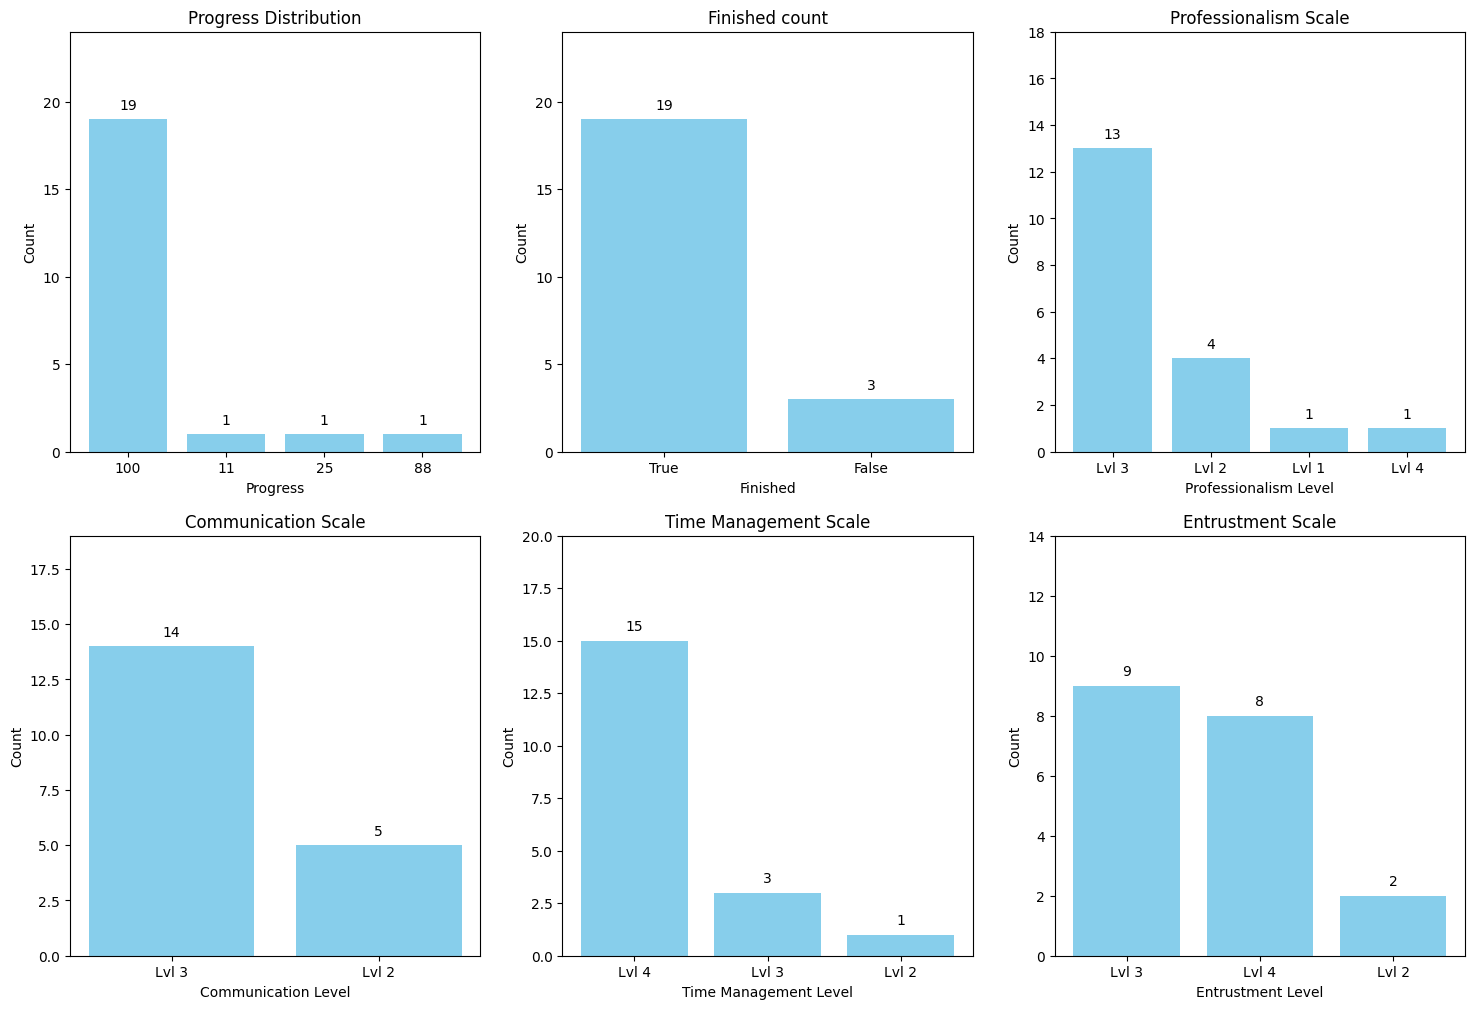

In [7]:
def extractPersonInfo(personName, choiceTextDf):
    data = choiceTextDf[choiceTextDf['RecipientFirstName'] == personName]
    # print(data)
    # print(data.describe())
    data = data.dropna(axis=1, how='all')
    # print(data.describe())
    data.head()

    data.drop(['RecipientFirstName', 'RecipientLastName', 'Status', 'IPAddress', "RecordedDate", "ResponseId",
                    'RecipientEmail', 'LocationLatitude',	'LocationLongitude', 'DistributionChannel', 'UserLanguage'], axis=1, inplace=True)
    data.drop(['Q2', 'Q3', 'Q4',	'Q5',	'Q6',	'Q7',	'Q12',	'Q132'], axis=1, inplace=True)
    data['StartDate'] = pd.to_datetime(data['StartDate'])
    data['EndDate'] = pd.to_datetime(data['EndDate'])
    data['Date'] = data['StartDate'].dt.date
    # data['Duration'] = (data['EndDate'] - data['StartDate']).dt.total_seconds()
    data.head(3)

    fig, axarr = plt.subplots(2, 3, figsize=(18, 12))

    #### Progress distribution
    progress=data['Progress']
    counts = progress.value_counts()
    counts.index = counts.index.astype(str)
    axarr[0, 0].bar(counts.index, counts.values, color='skyblue')
    axarr[0, 0].set_title('Progress Distribution')
    axarr[0, 0].set_xlabel('Progress')
    axarr[0, 0].set_ylabel('Count')
    axarr[0, 0].set_ylim(0, counts.max() + 5)
    for p in axarr[0, 0].patches:
        axarr[0, 0].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
   

    # Finished
    counts = data['Finished'].value_counts().reindex(['True', 'False'], fill_value=0)
    counts.index = counts.index.astype(str)
    axarr[0, 1].bar(counts.index, counts.values, color='skyblue')
    axarr[0, 1].set_title('Finished count')
    axarr[0, 1].set_xlabel('Finished')
    axarr[0, 1].set_ylabel('Count')
    axarr[0, 1].set_ylim(0, counts.max() + 5)
    for p in axarr[0, 1].patches:
        axarr[0, 1].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    print(f'%age finished: {counts["True"]}/{counts.sum()} = {counts["True"] / counts.sum() * 100:.2f}%')

    #### Critical incidents
    criticalI = data["Q59"].value_counts().reindex(['Yes', 'No'], fill_value=0)
    print(f'Number of Critical incidents:\nYes - {criticalI["Yes"]}\nNo - {criticalI["No"]}')

    ## Professionalism scale
    data["Q61"] = data["Q61"].str.extract('(Lvl \d)')
    counts = data["Q61"].value_counts()
    counts.index = counts.index.astype(str)
    axarr[0, 2].bar(counts.index, counts.values, color='skyblue')
    axarr[0, 2].set_title('Professionalism Scale')
    axarr[0, 2].set_xlabel('Professionalism Level')
    axarr[0, 2].set_ylabel('Count')
    axarr[0, 2].set_ylim(0, counts.max() + 5)
    for p in axarr[0, 2].patches:
        axarr[0, 2].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    

    # Communication scale
    data["Q62"] = data["Q62"].str.extract('(Lvl \d)')
    counts = data["Q62"].value_counts()
    counts.index = counts.index.astype(str)
    axarr[1, 0].bar(counts.index, counts.values, color='skyblue')
    axarr[1, 0].set_title('Communication Scale')
    axarr[1, 0].set_xlabel('Communication Level')
    axarr[1, 0].set_ylabel('Count')
    axarr[1, 0].set_ylim(0, counts.max() + 5)
    for p in axarr[1, 0].patches:
        axarr[1, 0].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Time management scale
    data["Q130"] = data["Q130"].str.extract('(Lvl \d)')
    counts = data["Q130"].value_counts()
    counts.index = counts.index.astype(str)
    axarr[1, 1].bar(counts.index, counts.values, color='skyblue')
    axarr[1, 1].set_title('Time Management Scale')
    axarr[1, 1].set_xlabel('Time Management Level')
    axarr[1, 1].set_ylabel('Count')
    axarr[1, 1].set_ylim(0, counts.max() + 5)
    for p in axarr[1, 1].patches:
        axarr[1, 1].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    

    # Entrustment scale
    data["Q63"] = data["Q63"].str.extract('(Lvl \d)')
    counts = data["Q63"].value_counts()
    counts.index = counts.index.astype(str)
    axarr[1, 2].bar(counts.index, counts.values, color='skyblue')
    axarr[1, 2].set_title('Entrustment Scale')
    axarr[1, 2].set_xlabel('Entrustment Level')
    axarr[1, 2].set_ylabel('Count')
    axarr[1, 2].set_ylim(0, counts.max() + 5)
    for p in axarr[1, 2].patches:
        axarr[1, 2].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    # plt.title(f'Analysis for {personName}')
    plt.show()

extractPersonInfo('Paloma', oral30002df)
extractPersonInfo('Zephaniah', oral30002df)
extractPersonInfo('Thuvasaki', oral30002df)

In [ ]:
choiceTextDf[choiceTextDf['Q12']=='DTC Perio'].head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,RecipientFirstName,RecipientEmail,ExternalReference,LocationLatitude,LocationLongitude,DistributionChannel,UserLanguage,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q12,Q12_3_TEXT,Q132,Q10,Q11,Q133,Q134,Q134_8_TEXT,Q13,Q14,Q15,Q16,Q162,Q17,Q18,Q166,Q167,Q20_1,Q21#1_1,Q21#1_2,Q21#1_3,Q21#1_4,Q21#1_5,Q21#1_6,Q21#1_7,Q21#1_8,Q21#1_9,Q21#1_10,Q21#1_11,Q21#1_12,Q21#1_13,Q21#1_14,Q21#1_15,Q21#1_16,Q21#2_1,Q21#2_2,Q21#2_3,Q21#2_4,Q21#2_5,Q21#2_6,Q21#2_7,Q21#2_8,Q21#2_9,Q21#2_10,Q21#2_11,Q21#2_12,Q21#2_13,Q21#2_14,Q21#2_15,Q21#2_16,Q22#1_1,Q22#1_2,Q22#1_3,Q22#1_4,Q22#1_5,Q22#1_6,Q22#1_7,Q22#1_8,Q22#1_9,Q22#1_10,Q22#1_11,Q22#1_12,Q22#1_13,Q22#1_14,Q22#1_15,Q22#1_16,Q22#2_1,Q22#2_2,Q22#2_3,Q22#2_4,Q22#2_5,Q22#2_6,Q22#2_7,Q22#2_8,Q22#2_9,Q22#2_10,Q22#2_11,Q22#2_12,Q22#2_13,Q22#2_14,Q22#2_15,Q22#2_16,Q23#1_1,Q23#1_2,Q23#1_3,Q23#1_4,Q23#1_5,Q23#1_6,Q23#1_7,Q23#2_1,Q23#2_2,Q23#2_3,Q23#2_4,Q23#2_5,Q23#2_6,Q23#2_7,Q24#1_1,Q24#1_2,Q24#1_3,Q24#1_4,Q24#1_5,Q24#2_1,Q24#2_2,Q24#2_3,Q24#2_4,Q24#2_5,Q165#1_1,Q165#1_2,Q165#1_3,Q165#1_4,Q165#1_5,Q165#1_6,Q165#1_7,Q165#1_8,Q165#2_1,Q165#2_2,Q165#2_3,Q165#2_4,Q165#2_5,Q165#2_6,Q165#2_7,Q165#2_8,Q25#1_1,Q25#1_2,Q25#1_3,Q25#1_4,Q25#1_5,Q25#1_6,Q25#1_7,Q25#1_8,Q25#1_9,Q25#1_10,Q25#2_1,Q25#2_2,Q25#2_3,Q25#2_4,Q25#2_5,Q25#2_6,Q25#2_7,Q25#2_8,Q25#2_9,Q25#2_10,Q26#1_1,Q26#1_2,Q26#1_3,Q26#1_4,Q26#1_5,Q26#1_6,Q26#1_7,Q26#1_8,Q26#2_1,Q26#2_2,Q26#2_3,Q26#2_4,Q26#2_5,Q26#2_6,Q26#2_7,Q26#2_8,Q27#1_1,Q27#1_2,Q27#1_3,Q27#1_4,Q27#1_5,Q27#1_6,Q27#1_7,Q27#1_8,Q27#1_9,Q27#1_10,Q27#2_1,Q27#2_2,Q27#2_3,Q27#2_4,Q27#2_5,Q27#2_6,Q27#2_7,Q27#2_8,Q27#2_9,Q27#2_10,Q28#1_1,Q28#1_2,Q28#1_3,Q28#1_4,Q28#1_5,Q28#1_6,Q28#1_7,Q28#1_8,Q28#2_1,Q28#2_2,Q28#2_3,Q28#2_4,Q28#2_5,Q28#2_6,Q28#2_7,Q28#2_8,Q29#1_1,Q29#1_2,Q29#1_3,Q29#1_4,Q29#1_5,Q29#1_6,Q29#1_7,Q29#1_8,Q29#1_9,Q29#1_10,Q29#1_11,Q29#1_12,Q29#1_13,Q29#1_14,Q29#2_1,Q29#2_2,Q29#2_3,Q29#2_4,Q29#2_5,Q29#2_6,Q29#2_7,Q29#2_8,Q29#2_9,Q29#2_10,Q29#2_11,Q29#2_12,Q29#2_13,Q29#2_14,Q30#1_1,Q30#1_2,Q30#1_3,Q30#1_4,Q30#1_5,Q30#1_6,Q30#2_1,Q30#2_2,Q30#2_3,Q30#2_4,Q30#2_5,Q30#2_6,Q31#1_1,Q31#1_2,Q31#1_3,Q31#1_4,Q31#1_5,Q31#2_1,Q31#2_2,Q31#2_3,Q31#2_4,Q31#2_5,Q32#1_1,Q32#1_2,Q32#1_3,Q32#1_4,Q32#1_5,Q32#2_1,Q32#2_2,Q32#2_3,Q32#2_4,Q32#2_5,Q33#1_1,Q33#1_2,Q33#1_3,Q33#1_4,Q33#1_5,Q33#2_1,Q33#2_2,Q33#2_3,Q33#2_4,Q33#2_5,Q34#1_1,Q34#1_2,Q34#1_3,Q34#1_4,Q34#1_5,Q34#2_1,Q34#2_2,Q34#2_3,Q34#2_4,Q34#2_5,Q136#1_1,Q136#1_2,Q136#1_3,Q136#1_4,Q136#1_5,Q136#2_1,Q136#2_2,Q136#2_3,Q136#2_4,Q136#2_5,Q35#1_1,Q35#1_2,Q35#1_3,Q35#1_4,Q35#1_5,Q35#1_6,Q35#1_7,Q35#1_8,Q35#1_9,Q35#1_10,Q35#2_1,Q35#2_2,Q35#2_3,Q35#2_4,Q35#2_5,Q35#2_6,Q35#2_7,Q35#2_8,Q35#2_9,Q35#2_10,Q36#1_1,Q36#1_2,Q36#1_3,Q36#1_4,Q36#1_5,Q36#1_6,Q36#1_7,Q36#1_8,Q36#1_9,Q36#1_10,Q36#1_11,Q36#1_12,Q36#1_13,Q36#1_14,Q36#2_1,Q36#2_2,Q36#2_3,Q36#2_4,Q36#2_5,Q36#2_6,Q36#2_7,Q36#2_8,Q36#2_9,Q36#2_10,Q36#2_11,Q36#2_12,Q36#2_13,Q36#2_14,Q163#1_1,Q163#1_2,Q163#1_3,Q163#1_4,Q163#1_5,Q163#2_1,Q163#2_2,Q163#2_3,Q163#2_4,Q163#2_5,Q137#1_1,Q137#1_2,Q137#1_3,Q137#1_4,Q137#1_5,Q137#1_6,Q137#1_7,Q137#1_8,Q137#1_9,Q137#1_10,Q137#1_11,Q137#1_12,Q137#2_1,Q137#2_2,Q137#2_3,Q137#2_4,Q137#2_5,Q137#2_6,Q137#2_7,Q137#2_8,Q137#2_9,Q137#2_10,Q137#2_11,Q137#2_12,Q138#1_1,Q138#1_2,Q138#1_3,Q138#1_4,Q138#1_5,Q138#1_6,Q138#1_7,Q138#1_8,Q138#1_9,Q138#1_10,Q138#1_11,Q138#1_12,Q138#2_1,Q138#2_2,Q138#2_3,Q138#2_4,Q138#2_5,Q138#2_6,Q138#2_7,Q138#2_8,Q138#2_9,Q138#2_10,Q138#2_11,Q138#2_12,Q139#1_1,Q139#1_2,Q139#1_3,Q139#1_4,Q139#1_5,Q139#1_6,Q139#1_7,Q139#1_8,Q139#1_9,Q139#1_10,Q139#1_11,Q139#1_12,Q139#2_1,Q139#2_2,Q139#2_3,Q139#2_4,Q139#2_5,Q139#2_6,Q139#2_7,Q139#2_8,Q139#2_9,Q139#2_10,Q139#2_11,Q139#2_12,Q140#1_1,Q140#1_2,Q140#1_3,Q140#1_4,Q140#1_5,Q140#1_6,Q140#1_7,Q140#1_8,Q140#1_9,Q140#1_10,Q140#1_11,Q140#1_12,Q140#2_1,Q140#2_2,Q140#2_3,Q140#2_4,Q140#2_5,Q140#2_6,Q140#2_7,Q140#2_8,Q140#2_9,Q140#2_10,Q140#2_11,Q140#2_12,Q141#1_1,Q141#1_2,Q141#1_3,Q141#1_4,Q141#1_5,Q141#1_6,Q141#1_7,Q141#1_8,Q141